*This is the initial implementation of the problem following meeting 2*

### Extracted Story
Several divisions of the Byzantine army are camped outside an enemy city, each division commanded by its own general. Each general observes the enemy and communicates his observation to the others. Each general then combines all the reported observations into a single plan of action (i.e., “attack” or “retreat”), for example, by using a majority vote. Communicating only by messengers, the generals must agree upon a common, and reasonable battle plan, however, one or more of them may be traitors who will try to confuse the others. All loyal generals must carry out the same plan, whereas the traitors may do anything they wish.

### Extracted Story (verbatim)
We imagine that several divisions of the Byzantine army are camped outside an enemy city, each division commanded by its own general. The generals can communicate with one another only by messenger. After observing the enemy, they must decide upon a common plan of action. However, some of the generals may be traitors, trying to prevent the loyal generals from reaching agreement.
...
All loyal generals decide upon the same plan of action... but the traitors may do anything they wish.
...
They loyal generals should not only reach agreement, but should agree upon a reasonable plan.

*Everything below this point is based on the verbatim version of the story.*

### User Stories
* As a GENERAL I want to...
  * make observations on an enemy city to decide upon a plan of action.
  * be able to communicate with other genrals to share our observations.
* As a LOYAL GENERAL I want to...
  * decide upon a reasonable plan of action so that my division does what is best.
  * decide upon the same plan of action as all other loyal generals so order within the army is maintained.
* As a DISLOYAL GENERAL I want to...
  * make false or contradicting observations to prevent the loyal generals from reaching agreement.
* As a MESSENGER I want to...
  * deliver messages between generals/divisons so they can reach upon some agreement.

### Assumptions
* There is only one messenger.
* "Enemy" and "Enemy City" are taken to refer to the same idea.
* A "reasonable plan" is assumed to mean that which wins a majority vote.
* The enemy/city is taken to have no functionality other than just "existing".
  * A city is assumed to be objectively either "attackable" or not, i.e., all generals make the same observations on the same city.
* A traitorous general simply "lies" to the other generals, i.e., he communicates the opposite of his observations to all generals.
* The observations that generals can make are either "attack" or "retreat".

### Design Decisions
* Enemy cities are simply instances of a class that essentially does nothing (yet).
* Each general works by first making an "objective" decision on an enemy. This is his true observation and not necessarily the one he communicates to the others.
* There is no tie breaker for the majority vote!

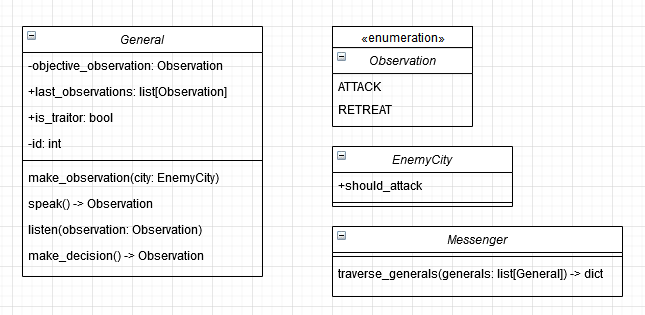

### Interesting Observations
Due to the absence of a tie breaker, in the event of a tie, generals simply return the first observation in their list of observations. This has interesting implications with how the rest of the code is structured in that loyal generals ALWAYS agree on a plan. This plan is not necessarily the "correct" one, but the point is that they never fail to reach agreement!

In [110]:
# This file is a part of the final year project "Story and Software" (CSC4006).
# Author: Konrad Mosoczy (Queen's University Belfast - QUB)
# https://github.com/konmos/csc4006 (also available on GitLab)
# ------------------------------------------------------------------------------
# This is the BGP notebook implementation 1.

import random
import logging
from enum import Enum, auto
from itertools import combinations
from collections import Counter, defaultdict

In [111]:
logging.basicConfig(level=100, force=True)

In [112]:
class Observation(Enum):
    '''
    Represents an observation that a general has made on a particular city.
    '''
    ATTACK = auto()
    RETREAT = auto()

In [113]:
class EnemyCity:
    def __init__(self, should_attack):
        # A city is modelled to be "objectively" either attackable or not
        self.should_attack = should_attack

In [114]:
class General:
    '''
    Represents a General who is either loyal or a traitor.
    '''
    # Used for easier representation
    next_id = 0

    def __init__(self, is_traitor=False):
        self._objective_observation = None
        self.last_observations = []
        self.is_traitor = is_traitor

        self._id = General.next_id
        General.next_id += 1
    
    def make_observation(self, city: EnemyCity):
        """Make the initial observation."""
        self._objective_observation = (Observation.RETREAT, Observation.ATTACK)[city.should_attack]
    
    def speak(self):
        """
        Return an observation.
        """
        if not self.is_traitor:
            return self._objective_observation

        # Traitors lie
        if self._objective_observation is Observation.ATTACK:
            return Observation.RETREAT
        
        return Observation.ATTACK
    
    def listen(self, observation):
        """
        Receive an observation.
        """
        self.last_observations.append(observation)
    
    def make_decision(self):
        return Counter(self.last_observations).most_common(1)[0][0]
    
    def __repr__(self) -> str:
        return f'<General {self._id} [{"t" if self.is_traitor else "l"}]>'

In [115]:
class Messenger:
    @staticmethod
    def traverse_generals(generals):
        '''
        Traverse the network created by pairing every general with every other general.
        Calls the `speak`, and `listen` methods of each `General` instance.
        Effectively creates a node graph of generals and messages.

        :return: The resulting communication graph represented as a dictionary.
        '''
        # {General: {target: message, ...}, ...}
        comms = defaultdict(dict)
        
        for x, y in combinations(generals, 2):
            y_speak = y.speak()
            x_speak = x.speak()
            
            x.listen(y_speak)
            y.listen(x_speak)
            
            comms[y][x] = y_speak
            comms[x][y] = x_speak
        
        return comms

In [116]:
def main(total_generals, num_traitors=-1, should_attack=None):
    '''
    Run the main simulation between a number of generals.

    :param total_generals: The TOTAL number of generals
    :param num_traitors: The number of traitors.
        Can be expressed either as...
            int >= 0                 for an absolute size
            float >= 0.0 and <= 1.0  for a percentage of `total_generals`
            int < 0                  for random distribution
    :param should_attack: Should the city be objectively attackable or not.
        (default: random)
    :return: The PoA agreed to by the loyal generals.
        ("retreat", "attack" or None)
    '''
    n_traitors = 0
    
    if isinstance(num_traitors, int):
        if num_traitors >= 0:
            n_traitors = num_traitors
        else:
            n_traitors = int(total_generals * random.random())
    elif isinstance(num_traitors, float) and 0 <= num_traitors <= 1:
        n_traitors = int(total_generals * num_traitors)
    
    generals = [General(False) for _ in range(total_generals - n_traitors)] + \
               [General(True) for _ in range(n_traitors)]
    
    if should_attack is not None:
        city = EnemyCity(should_attack)
    else:
        city = EnemyCity(random.choice([True, False]))
    
    logging.info(
        f'Running with {total_generals} total generals of which'
        f' {n_traitors} are traitorous. EnemyCity.should_attack == {city.should_attack}\n'
    )
    
    # Each general makes an objective observation
    for g in generals:
        g.make_observation(city)
    
    # Each general communicates his observation (or not)
    m = Messenger()
    communications = m.traverse_generals(generals)
    
    # Each general comes up with a plan of action
    loyal_poa, agreed_plan = set(), None
    
    for g in generals:
        decision = g.make_decision()
        
        if not g.is_traitor:
            loyal_poa.add(decision)
    
    if len(loyal_poa) != 1:
        logging.info('Loyal Generals cannot agree on a plan of action!!!\n')
    else:
        agreed_plan = loyal_poa.pop()
        logging.info(f'Loyal Generals have agreed on: {agreed_plan}\n')
    
    total_a, total_r = 0, 0

    for g in communications:
        a, r = 0, 0
        
        for msg in communications[g].values():
            if msg is Observation.ATTACK:
                a += 1
            else:
                r += 1
        
        total_a += a
        total_r += r

        logging.debug(
            f'{"[!] " if g.is_traitor else ""}'
            f'General {g._id} has made the objective observation of {g._objective_observation.name}'
            f' and reported ATTTACK {a} times and RETREAT {r} times'
        )
    
    return agreed_plan, total_a, total_r, communications

In [117]:
def test_runner(test_cases, test_runs):
    """
    A simple test runner for this implementation of the BGP.
    
    :param test_cases: a list of tuples specifying what
        tests should be run in the format [(num_generals, num_traitors), ...]
    :param test_runs: the number of times that each test should be run
    """
    # [(num_generals, num_traitors), ...]
    for test in test_cases:
        print(f'\n\nRunning test {test}\n{"-"*20}')

        for _ in range(test_runs):
            plan, a, r, comms = main(*test, True)
            print(f'\n[PLAN={plan} ATTACK={a} RETREAT={r}]\n')

            for general in comms:
                observations = [0, 0]  # attack, retreat

                for observation in general.last_observations:
                    if observation is Observation.ATTACK:
                        observations[0] += 1
                    else:
                        observations[1] += 1
                
                print(f'{general}: attack={observations[0]} retreat={observations[1]}')

In [118]:
if __name__ == '__main__':
    # m = 10  # 10 traitors
    
    # # The loyal generals should all agree to the same reasonable plan
    # main((3 * m) + 1, m)
    
    # # Here, the loyal generals *should* fail to 
    # # reach agreement or agree to an "unreasonable" plan.
    # # (This doesn't actually happen...)
    # main((3 * m), m)  # Note the missing `+1`
    
    # main(15, 10)

    tests = [
        (10, 0),
        (10, 2),
        (10, 4),
        (10, 6),
        (10, 8),
        (10, 10)
    ]

    test_runner(tests, 3)



Running test (10, 0)
--------------------

[PLAN=Observation.ATTACK ATTACK=90 RETREAT=0]

<General 1 [l]>: attack=9 retreat=0
<General 0 [l]>: attack=9 retreat=0
<General 2 [l]>: attack=9 retreat=0
<General 3 [l]>: attack=9 retreat=0
<General 4 [l]>: attack=9 retreat=0
<General 5 [l]>: attack=9 retreat=0
<General 6 [l]>: attack=9 retreat=0
<General 7 [l]>: attack=9 retreat=0
<General 8 [l]>: attack=9 retreat=0
<General 9 [l]>: attack=9 retreat=0

[PLAN=Observation.ATTACK ATTACK=90 RETREAT=0]

<General 11 [l]>: attack=9 retreat=0
<General 10 [l]>: attack=9 retreat=0
<General 12 [l]>: attack=9 retreat=0
<General 13 [l]>: attack=9 retreat=0
<General 14 [l]>: attack=9 retreat=0
<General 15 [l]>: attack=9 retreat=0
<General 16 [l]>: attack=9 retreat=0
<General 17 [l]>: attack=9 retreat=0
<General 18 [l]>: attack=9 retreat=0
<General 19 [l]>: attack=9 retreat=0

[PLAN=Observation.ATTACK ATTACK=90 RETREAT=0]

<General 21 [l]>: attack=9 retreat=0
<General 20 [l]>: attack=9 retreat=0
<General